In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
#path = '/export/data1/brodriguez/'
path = '/vol/aibn1081/data1/brodriguez/'

# Opening CO(2-1) data cube for UGC12250

In [3]:
CO_cube = SpectralCube.read(path+'UGC12250_7m_co21_pbcor.fits')

In [4]:
CO_cube.beam

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [5]:
CO_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 343.8995616667  12.79027758333  7613756.253316  
CRPIX : 61.0  61.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.0004166666666667  0.0004166666666667  -5081.347213086  
NAXIS : 120  120  197

## Extracting the minimal valid subcube

In [6]:
CO_cube = CO_cube.minimal_subcube()

## Opening Pipe3D output file for UGC12250

In [7]:
hdu_list = fits.open(path+'UGC12250.Pipe3D.cube.fits')

In [8]:
hdu_list.info()

Filename: /vol/aibn1081/data1/brodriguez/UGC12250.Pipe3D.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU     515   ()      
  1  SSP           1 ImageHDU       118   (160, 149, 21)   float64   
  2  SFH           1 ImageHDU      1608   (160, 149, 319)   float64   
  3  INDICES       1 ImageHDU        79   (160, 149, 70)   float64   
  4  ELINES        1 ImageHDU        68   (160, 149, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1310   (160, 149, 432)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      3134   (160, 149, 1040)   float64   
  7  GAIA_MASK     1 ImageHDU        10   (160, 149)   float64   
  8  SELECT_REG    1 ImageHDU        10   (160, 149)   int64   


In [1]:
#hdu_list[5].header # check header for emission line flux and flux error indices

In [9]:
frames = [hdu_list[5].data[i] for i in [26,28,41,45,46,49,242,244,257,261,262,265]]
frames = np.array(frames)

In [10]:
region = hdu_list[8].data

In [9]:
# flux_OIII5007 -> 0, err_OIII5007 -> 6
# flux_Hbeta    -> 1, err_Hbeta    -> 7
# flux_OI6300   -> 2, err_OI6300   -> 8
# flux_Halpha   -> 3, err_Halpha   -> 9
# flux_NII6584  -> 4, err_NII6584  -> 10
# flux_SII6717  -> 5, err_SII6717  -> 11

# V_band  -> 12
# M_star  -> 13

In [11]:
for frame in frames:
    frame[region<1] = np.nan

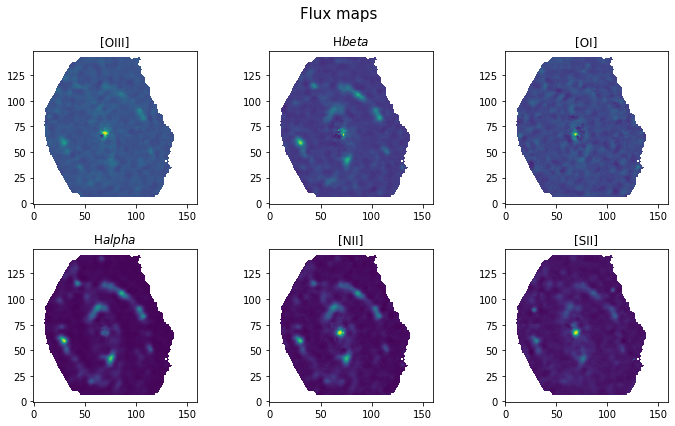

In [12]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,image,name in zip(axs.ravel(),frames[:6],['[OIII]',r'H$\beta$','[OI]',r'H\$alpha$','[NII]','[SII]']):
    ax.imshow(image,origin='lower')
    ax.set_title(name)
fig.suptitle('Flux maps',fontsize=15)
fig.tight_layout()
plt.show()

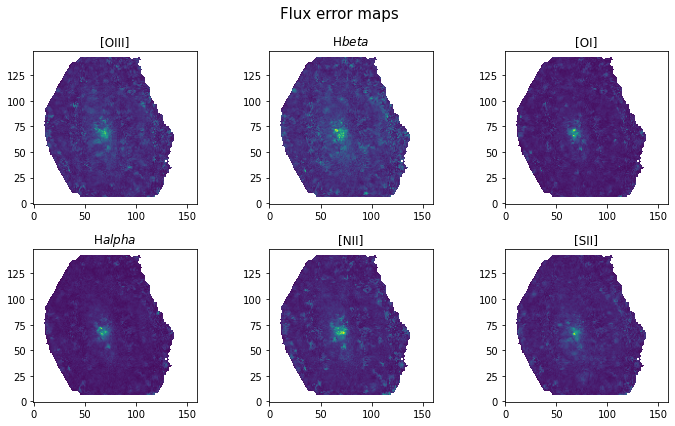

In [13]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,image,name in zip(axs.ravel(),frames[6:],['[OIII]',r'H$\beta$','[OI]',r'H\$alpha$','[NII]','[SII]']):
    ax.imshow(image,origin='lower')
    ax.set_title(name)
fig.suptitle('Flux error maps',fontsize=15)
fig.tight_layout()
plt.show()

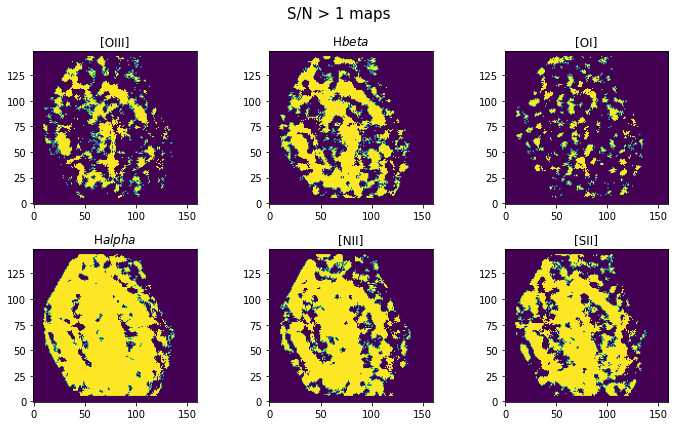

In [14]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
for ax,flux,err,name in zip(axs.ravel(),frames[:6],frames[6:],['[OIII]',r'H$\beta$','[OI]',r'H\$alpha$','[NII]','[SII]']):
    ax.imshow((flux/err)>1,origin='lower')
    ax.set_title(name)
fig.suptitle('S/N > 1 maps',fontsize=15)
fig.tight_layout()
plt.show()

In [15]:
wcs_califa = WCS(hdu_list[0].header).to_header()

In [16]:
wcs_califa['CRPIX3']=0
wcs_califa['CTYPE3']='VRAD'
wcs_califa['CUNIT3']='m/s'
wcs_califa

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 69.0 / Pixel coordinate of reference point            
CRPIX2  =                 63.0 / Pixel coordinate of reference point            
CRPIX3  =                    0 / Pixel coordinate of reference point            
PC1_1   = -0.00013888888888888 / Coordinate transformation matrix element       
PC2_2   =  0.00013888888888889 / Coordinate transformation matrix element       
PC3_3   =                  2.0 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / [Angstrom] Coordinate increment at reference po
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'm/s     '        

In [48]:
'''ONLY for masking with S/N>1'''
for signal,noise in zip(frames[:6],frames[6:12]):
    signal[signal/noise<=1] = np.nan

In [49]:
frames_cube = SpectralCube(data=frames,wcs=WCS(wcs_califa))
frames_cube = frames_cube.with_mask(region)

In [18]:
beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

In [19]:
beam_list = radio_beam.Beams(beams=[CO_cube.beam,beam_califa])
common_beam = radio_beam.commonbeam.common_2beams(beam_list)
common_beam

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [50]:
frames_cube = frames_cube.with_beam(beam_califa)

In [51]:
frames_cube_convolved = frames_cube.convolve_to(beam_CO)

In [22]:
target_header = CO_cube.header

In [28]:
target_header['NAXIS3'] = None
target_header['CRPIX3'] = None
target_header['CDELT3'] = None
target_header['CUNIT3'] = None
target_header['CTYPE3'] = None
target_header['CRVAL3'] = None

In [23]:
target_header['NAXIS'] = 2
target_header['WCSAXES'] = 2

In [24]:
del target_header['NAXIS3'], target_header['CRPIX3'],target_header['CDELT3'],target_header['CUNIT3'],target_header['CTYPE3'],target_header['CRVAL3']

In [30]:
target_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2                                                  
NAXIS1  =                   74                                                  
NAXIS2  =                   72                                                  
NAXIS3  =                                                                       
BMAJ    =   2.623496323459E-03                                                  
BMIN    =   1.505816915164E-03                                                  
BPA     =  -3.571292199102E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'UGC12250'                                                            
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   2.246830823985E+

In [52]:
reprojected_list = []
for frame in frames_cube_convolved:
    reprojected, footprint = reproject_exact((frame,WCS(wcs_califa).celestial),target_header)
    reprojected_list.append(reprojected)
reprojected_list = np.array(reprojected_list)

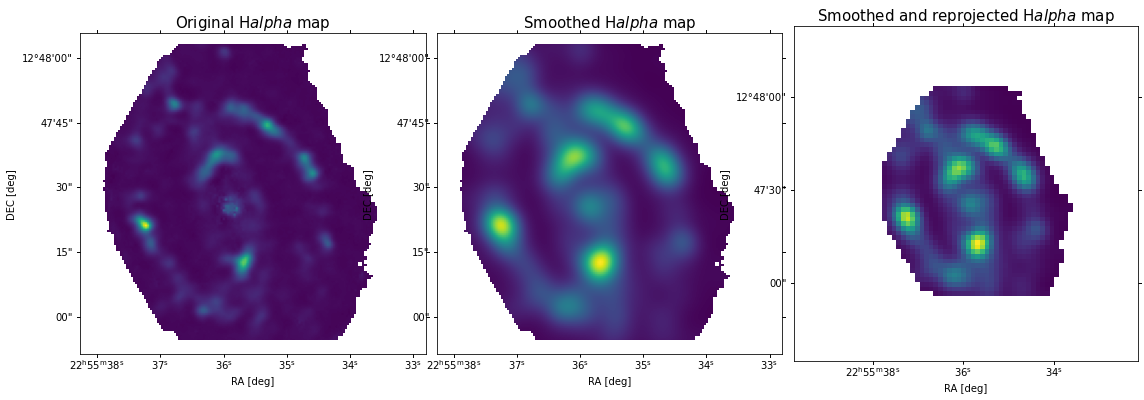

In [27]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
for ax,frame,label in zip([ax1,ax2,ax3],[np.array(frames_cube[3,:,:]),np.array(frames_cube_convolved[3,:,:]),reprojected_list[3]],
                          ['Original','Smoothed','Smoothed and reprojected']):
    ax.imshow(frame, origin='lower')
    ax.set_title(label+r' H$\alpha$ map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
#ax.coords['dec'].set_axislabel_position('r')
#ax.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

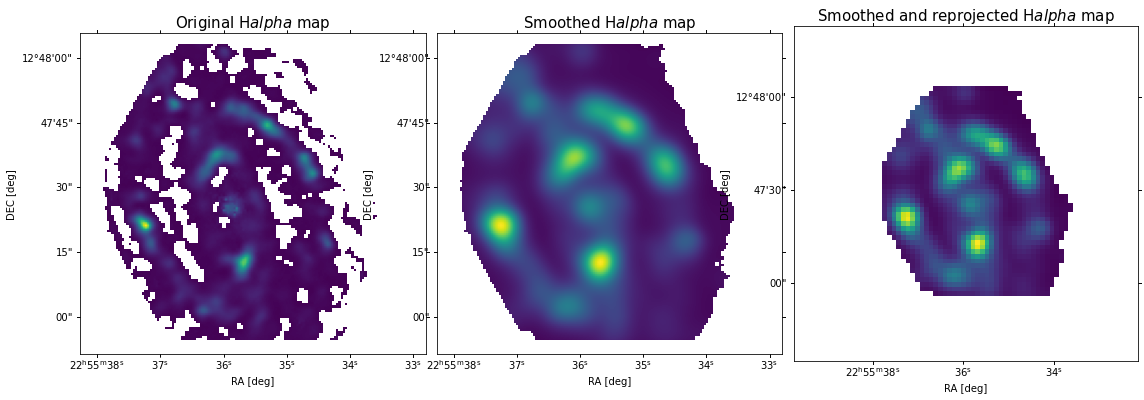

In [53]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
for ax,frame,label in zip([ax1,ax2,ax3],[np.array(frames_cube[3,:,:]),np.array(frames_cube_convolved[3,:,:]),reprojected_list[3]],
                          ['Original','Smoothed','Smoothed and reprojected']):
    ax.imshow(frame, origin='lower')
    ax.set_title(label+r' H$\alpha$ map',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
#ax.coords['dec'].set_axislabel_position('r')
#ax.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

In [9]:
# flux_OIII5007 -> 0, err_OIII5007 -> 6
# flux_Hbeta    -> 1, err_Hbeta    -> 7
# flux_OI6300   -> 2, err_OI6300   -> 8
# flux_Halpha   -> 3, err_Halpha   -> 9
# flux_NII6584  -> 4, err_NII6584  -> 10
# flux_SII6717  -> 5, err_SII6717  -> 11

# V_band  -> 12
# M_star  -> 13

In [55]:
logratio_OIIIHb = np.log10(frames[0]/frames[1])
logratio_NIIHa  = np.log10(frames[4]/frames[3])
logratio_SIIHa  = np.log10(frames[5]/frames[3])
logratio_OIHa   = np.log10(frames[2]/frames[3])

In [56]:
logratio_rpj_OIIIHb = np.log10(reprojected_list[0]/reprojected_list[1])
logratio_rpj_NIIHa  = np.log10(reprojected_list[4]/reprojected_list[3])
logratio_rpj_SIIHa  = np.log10(reprojected_list[5]/reprojected_list[3])
logratio_rpj_OIHa   = np.log10(reprojected_list[2]/reprojected_list[3])

In [57]:
maskSF_NII = ((0.61/(logratio_NIIHa-0.47)+1.19)>logratio_OIIIHb)&(logratio_NIIHa<0.47)
maskSy_NII = (((0.61/(logratio_NIIHa-0.47)+1.19)<=logratio_OIIIHb)|(logratio_NIIHa>=0.47))&(1.01*logratio_NIIHa+0.48<logratio_OIIIHb)
maskLI_NII = (((0.61/(logratio_NIIHa-0.47)+1.19)<=logratio_OIIIHb)|(logratio_NIIHa>=0.47))&(1.01*logratio_NIIHa+0.48>logratio_OIIIHb)
maskSF_SII = (((0.72/(logratio_SIIHa-0.32)+1.30)>logratio_OIIIHb)&(logratio_SIIHa<0.32))
maskSy_SII = (((0.72/(logratio_SIIHa-0.32)+1.30)<=logratio_OIIIHb)|(logratio_SIIHa>=0.32))&(1.89*logratio_SIIHa+0.76<logratio_OIIIHb)
maskLI_SII = (((0.72/(logratio_SIIHa-0.32)+1.30)<=logratio_OIIIHb)|(logratio_SIIHa>=0.32))&(1.89*logratio_SIIHa+0.76>logratio_OIIIHb)
maskSF_OI  = (((0.73/(logratio_OIHa +0.59)+1.33)>logratio_OIIIHb)&(logratio_OIHa<-0.59))
maskSy_OI  = (((0.73/(logratio_OIHa +0.59)+1.33)<=logratio_OIIIHb)|(logratio_OIHa>=-0.59))&(1.18*logratio_OIHa+1.3<logratio_OIIIHb)
maskLI_OI  = (((0.73/(logratio_OIHa +0.59)+1.33)<=logratio_OIIIHb)|(logratio_OIHa>=-0.59))&(1.18*logratio_OIHa+1.3>logratio_OIIIHb)

In [58]:
maskSF_rpj_NII = ((0.61/(logratio_rpj_NIIHa-0.47)+1.19)>logratio_rpj_OIIIHb)&(logratio_rpj_NIIHa<0.47)
maskSy_rpj_NII = (((0.61/(logratio_rpj_NIIHa-0.47)+1.19)<=logratio_rpj_OIIIHb)|(logratio_rpj_NIIHa>=0.47))&(1.01*logratio_rpj_NIIHa+0.48<logratio_rpj_OIIIHb)
maskLI_rpj_NII = (((0.61/(logratio_rpj_NIIHa-0.47)+1.19)<=logratio_rpj_OIIIHb)|(logratio_rpj_NIIHa>=0.47))&(1.01*logratio_rpj_NIIHa+0.48>logratio_rpj_OIIIHb)
maskSF_rpj_SII = (((0.72/(logratio_rpj_SIIHa-0.32)+1.30)>logratio_rpj_OIIIHb)&(logratio_rpj_SIIHa<0.32))
maskSy_rpj_SII = (((0.72/(logratio_rpj_SIIHa-0.32)+1.30)<=logratio_rpj_OIIIHb)|(logratio_rpj_SIIHa>=0.32))&(1.89*logratio_rpj_SIIHa+0.76<logratio_rpj_OIIIHb)
maskLI_rpj_SII = (((0.72/(logratio_rpj_SIIHa-0.32)+1.30)<=logratio_rpj_OIIIHb)|(logratio_rpj_SIIHa>=0.32))&(1.89*logratio_rpj_SIIHa+0.76>logratio_rpj_OIIIHb)
maskSF_rpj_OI  = (((0.73/(logratio_rpj_OIHa +0.59)+1.33)>logratio_rpj_OIIIHb)&(logratio_rpj_OIHa<-0.59))
maskSy_rpj_OI  = (((0.73/(logratio_rpj_OIHa +0.59)+1.33)<=logratio_rpj_OIIIHb)|(logratio_rpj_OIHa>=-0.59))&(1.18*logratio_rpj_OIHa+1.3<logratio_rpj_OIIIHb)
maskLI_rpj_OI  = (((0.73/(logratio_rpj_OIHa +0.59)+1.33)<=logratio_rpj_OIIIHb)|(logratio_rpj_OIHa>=-0.59))&(1.18*logratio_rpj_OIHa+1.3>logratio_rpj_OIIIHb)

In [59]:
map_NII = np.zeros(frames[0].shape)
map_NII[maskSF_NII] = 1.
map_NII[maskSy_NII] = 2.
map_NII[maskLI_NII] = 3.
map_SII = np.zeros(frames[0].shape)
map_SII[maskSF_SII] = 1.
map_SII[maskSy_SII] = 2.
map_SII[maskLI_SII] = 3.
map_OI = np.zeros(frames[0].shape)
map_OI[maskSF_OI] = 1.
map_OI[maskSy_OI] = 2.
map_OI[maskLI_OI] = 3.

In [60]:
map_rpj_NII = np.zeros(reprojected_list[0].shape)
map_rpj_NII[maskSF_rpj_NII] = 1.
map_rpj_NII[maskSy_rpj_NII] = 2.
map_rpj_NII[maskLI_rpj_NII] = 3.
map_rpj_SII = np.zeros(reprojected_list[0].shape)
map_rpj_SII[maskSF_rpj_SII] = 1.
map_rpj_SII[maskSy_rpj_SII] = 2.
map_rpj_SII[maskLI_rpj_SII] = 3.
map_rpj_OI = np.zeros(reprojected_list[0].shape)
map_rpj_OI[maskSF_rpj_OI] = 1.
map_rpj_OI[maskSy_rpj_OI] = 2.
map_rpj_OI[maskLI_rpj_OI] = 3.

In [31]:
xNII = np.linspace(-2,0.25,100)
yNII = 0.61/(xNII-0.47) + 1.19
xSII = np.linspace(-1.5,0.1,100)
ySII = 0.72/(xSII-0.32) + 1.3
xOI  = np.linspace(-2.5,-0.8,100)
yOI  = 0.73/(xOI+0.59) + 1.33

## Results without masking with S/N in the emission line fluxes:

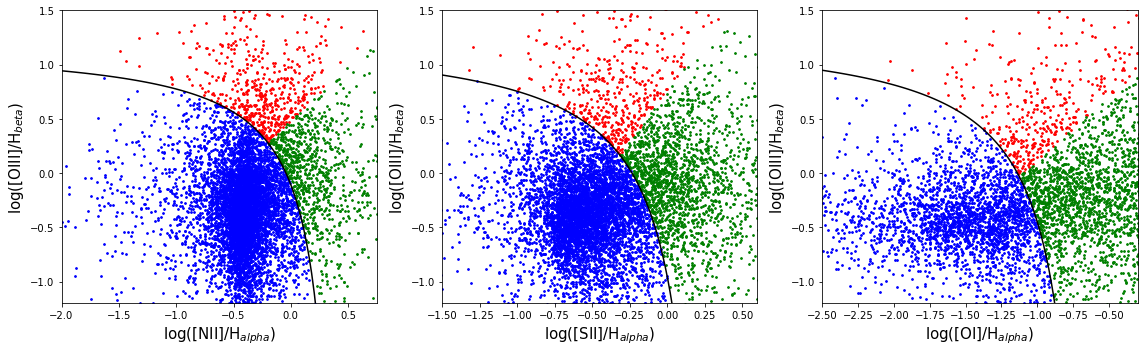

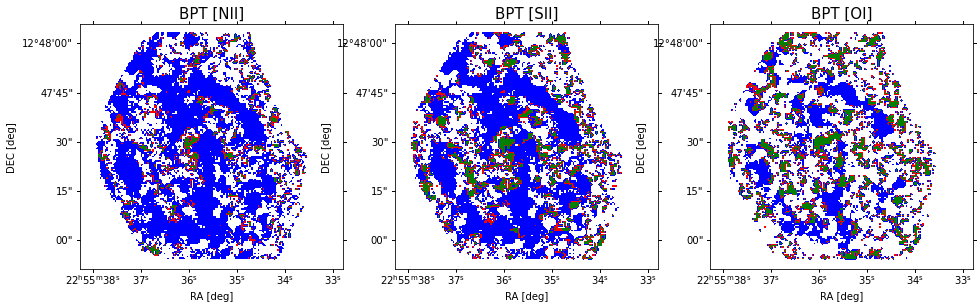

In [46]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_NIIHa,logratio_SIIHa,logratio_OIHa],
                             [maskSF_NII,maskSF_SII,maskSF_OI],[maskSy_NII,maskSy_SII,maskSy_OI],
                             [maskLI_NII,maskLI_SII,maskLI_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[maskSF],logratio_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From original maps',fontsize=15)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_NII,map_SII,map_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
plt.show()

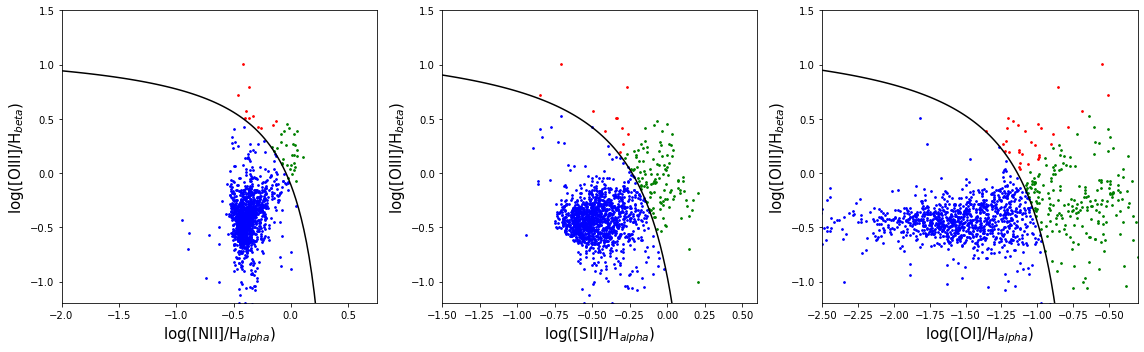

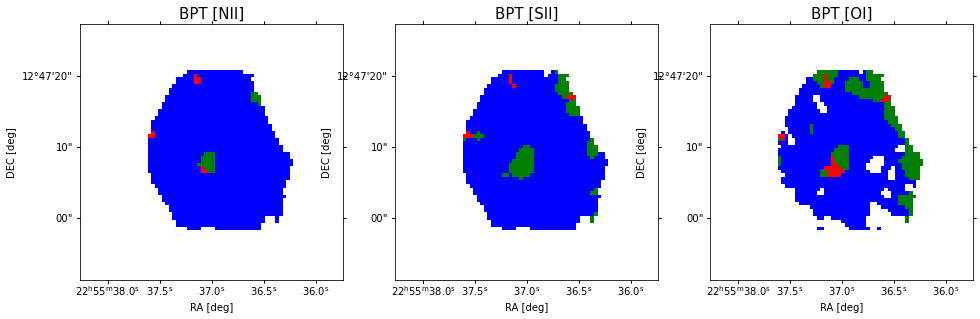

In [47]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_rpj_NIIHa,logratio_rpj_SIIHa,logratio_rpj_OIHa],
                             [maskSF_rpj_NII,maskSF_rpj_SII,maskSF_rpj_OI],[maskSy_rpj_NII,maskSy_rpj_SII,maskSy_rpj_OI],
                             [maskLI_rpj_NII,maskLI_rpj_SII,maskLI_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[maskSF],logratio_rpj_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_rpj_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_rpj_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From smoothed and reprojected maps',fontsize=15)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_rpj_NII,map_rpj_SII,map_rpj_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
plt.show()

## Results after masking with S/N>1 in the emission line fluxes:

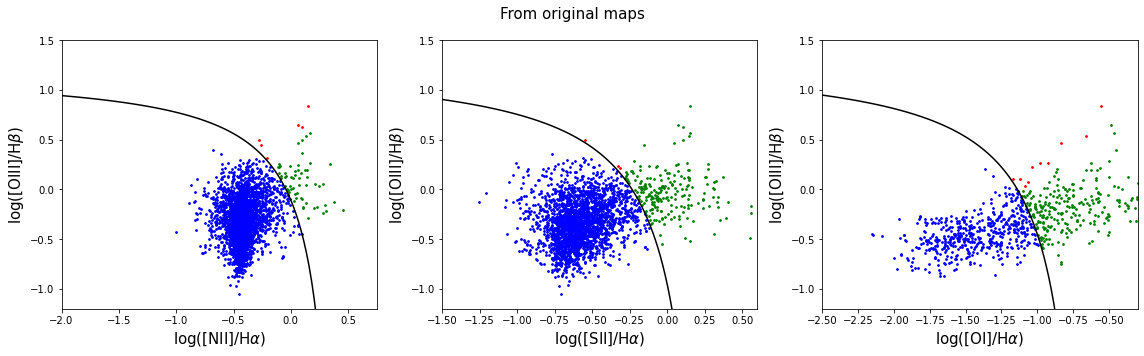

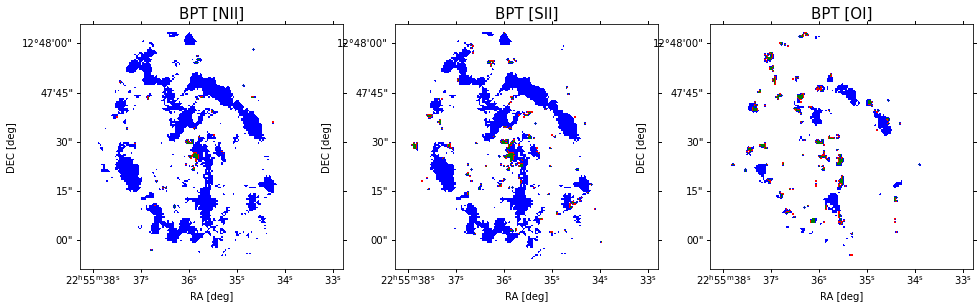

In [69]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_NIIHa,logratio_SIIHa,logratio_OIHa],
                             [maskSF_NII,maskSF_SII,maskSF_OI],[maskSy_NII,maskSy_SII,maskSy_OI],
                             [maskLI_NII,maskLI_SII,maskLI_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[maskSF],logratio_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From original maps',fontsize=15)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_NII,map_SII,map_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
plt.show()

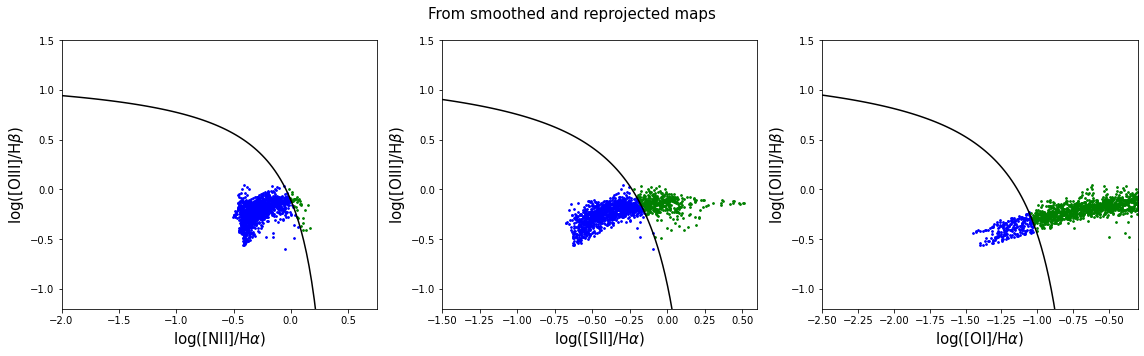

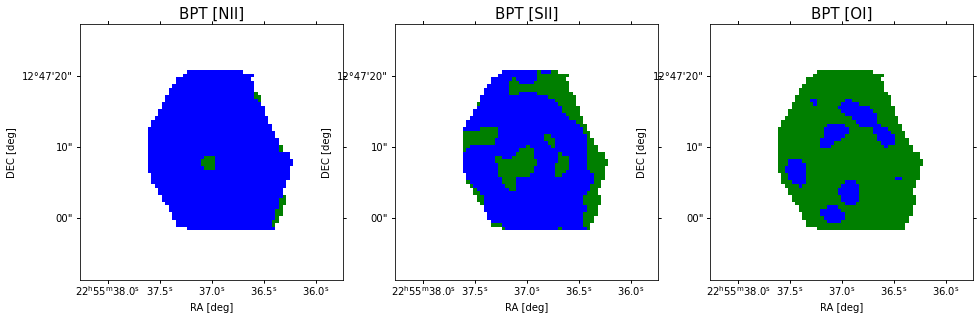

In [68]:
fig1, axs1 = plt.subplots(1,3,figsize=(16,5))
for ax,label,ratio,maskSF,maskSy,maskLI,x,y in zip(axs1.ravel(),['NII','SII','OI'],
                             [logratio_rpj_NIIHa,logratio_rpj_SIIHa,logratio_rpj_OIHa],
                             [maskSF_rpj_NII,maskSF_rpj_SII,maskSF_rpj_OI],[maskSy_rpj_NII,maskSy_rpj_SII,maskSy_rpj_OI],
                             [maskLI_rpj_NII,maskLI_rpj_SII,maskLI_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[maskSF],logratio_rpj_OIIIHb[maskSF],c='b',s=3.)
    ax.scatter(ratio[maskSy],logratio_rpj_OIIIHb[maskSy],c='r',s=3.)
    ax.scatter(ratio[maskLI],logratio_rpj_OIIIHb[maskLI],c='g',s=3.)
    ax.set_xlabel('log(['+label+r']/H$\alpha$)',fontsize=15)
    ax.set_ylabel(r'log([OIII]/H$\beta$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
fig1.suptitle('From smoothed and reprojected maps',fontsize=15)
fig1.tight_layout()
fig2, axs2 =plt.subplots(1,3,figsize=(16,5),subplot_kw={'projection':WCS(wcs_califa).celestial})
for ax,MAP,label in zip(axs2.ravel(),[map_rpj_NII,map_rpj_SII,map_rpj_OI],['NII','SII','OI']):
    ax.imshow(MAP,origin='lower',cmap=ListedColormap(['w', 'b', 'r', 'g']),vmin=-0.5,vmax=3.5)
    ax.set_title('BPT ['+label+']',fontsize=15)
    ax.coords['ra'].set_axislabel('RA [deg]')
    ax.coords['dec'].set_axislabel('DEC [deg]')
plt.show()